
Chapter 7 – Ensemble Learning and Random Forests

Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# Voting Classifiers

In [2]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)


Code to generate Figure 7–3. The law of large numbers:

Saving figure law_of_large_numbers_plot


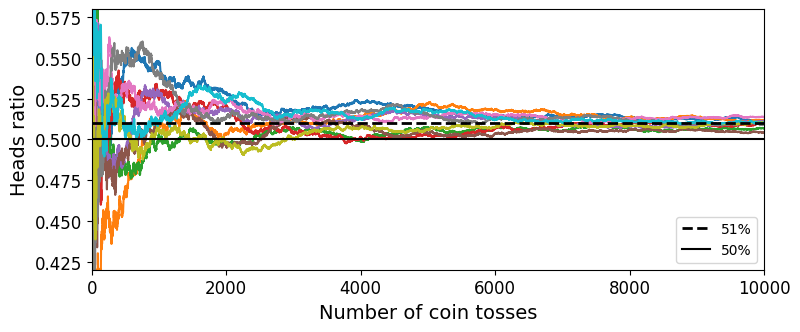

In [3]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

due to the law of large
 numbers: as you keep tossing the coin, the ratio of heads gets closer and closer to the
 probability of heads (51%). Figure 7-3 shows 10 series of biased coin tosses. You can
 see that as the number of tosses increases, the ratio of heads approaches 51%. Eventu
ally all 10 series end up so close to 51% that they are consistently above 50%.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

 The following code creates and trains a voting classifier in Scikit-Learn, composed of
 three diverse classifiers (the training set is the moons dataset, introduced in Chap
ter 5):


In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [6]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

 Let’s look at each classifier’s accuracy on the test set

In [7]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912



Note: the results in this notebook may differ slightly from the book, as Scikit-Learn algorithms sometimes get tweaked.

Soft voting:

In [8]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [9]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# Bagging and Pasting
# Bagging and Pasting in Scikit-Learn

 One way to get a diverse set of classifiers is to use very different training algorithms,
 as just discussed. Another approach is to use the same training algorithm for every
 predictor and train them on different random subsets of the training set. When sam

pling is performed with replacement, this method is called bagging1 (short for boot
strap aggregating2). When sampling is performed without replacement, it is called
 pasting.

 In other words, both bagging and pasting allow training instances to be sampled sev
eral times across multiple predictors, but only bagging allows training instances to be
 sampled several times for the same predictor. This sampling and training process is
 represented in Figure 7-4

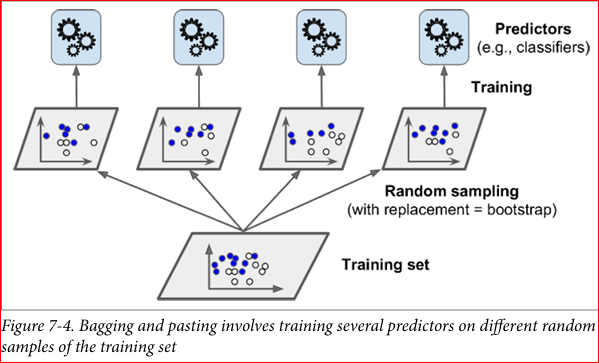



# Bagging and Pasting in Scikit-Learn

Scikit-Learn offers a simple API for both bagging and pasting with the BaggingClas
 sifier class (or BaggingRegressor for regression). The following code trains an
 ensemble of 500 Decision Tree classifiers:5 each is trained on 100 training instances
 randomly sampled from the training set with replacement (this is an example of bag
ging, but if you want to use pasting instead, just set bootstrap=False). The n_jobs
 parameter tells Scikit-Learn the number of CPU cores to use for training and predic
tions (–1 tells Scikit-Learn to use all available cores):

In [10]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [11]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [12]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


**Code to generate Figure 7–5. A single Decision Tree (left) versus a bagging ensemble of 500 trees (right):**

 Figure 7-5 compares the decision boundary of a single Decision Tree with the deci
sion boundary of a bagging ensemble of 500 trees (from the preceding code), both
 trained on the moons dataset. As you can see, the ensemble’s predictions will likely
 generalize much better than the single Decision Tree’s predictions: the ensemble has a
 comparable bias but a smaller variance (it makes roughly the same number of errors
 on the training set, but the decision boundary is less irregular).

In [13]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Saving figure decision_tree_without_and_with_bagging_plot


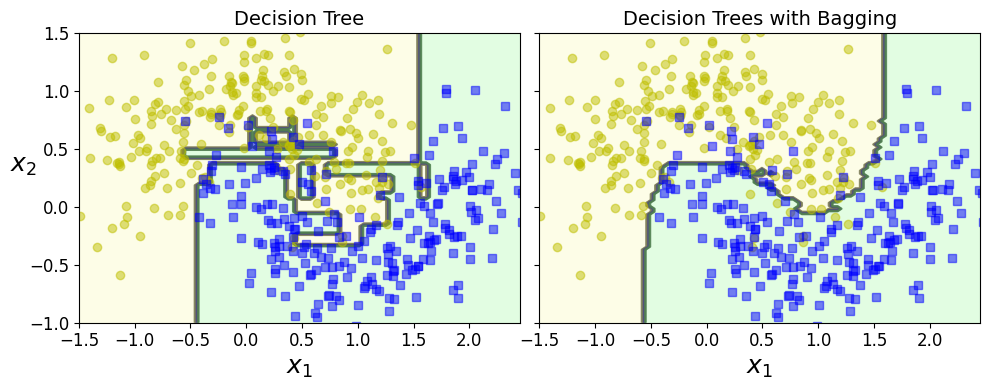

In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()



# Out-of-Bag evaluation

 With bagging, some instances may be sampled several times for any given predictor,
 while others may not be sampled at all. By default a BaggingClassifier samples m
 training instances with replacement (bootstrap=True), where m is the size of the
 training set. This means that only about 63% of the training instances are sampled on
 average for each predictor.6 The remaining 37% of the training instances that are not
 sampled are called out-of-bag (oob) instances. Note that they are not the same 37%
 for all predictors

Since a predictor never sees the oob instances during training, it can be evaluated on
 these instances, without the need for a separate validation set. You can evaluate the
 ensemble itself by averaging out the oob evaluations of each predictor.
 In Scikit-Learn, you can set oob_score=True when creating a BaggingClassifier to
 request an automatic oob evaluation after training. The following code demonstrates
 this. The resulting evaluation score is available through the oob_score_ variable

In [15]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

 According to this oob evaluation, this BaggingClassifier is likely to achieve about
 89.8% accuracy on the test set. Let’s verify this:

In [17]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

 We get 91.2% accuracy on the test set—close enough!

 The oob decision function for each training instance is also available through the
 oob_decision_function_ variable. In this case (since the base estimator has a pre
 dict_proba() method), the decision function returns the class probabilities for each
 training instance. For example, the oob evaluation estimates that the first training
 instance has a 68.25% probability of belonging to the positive class (and 31.75% of
 belonging to the negative class):

In [18]:

bag_clf.oob_decision_function_

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.


# Random Forests

 The following code uses all
 available CPU cores to train a Random Forest classifier with 500 trees (each limited
 to maximum 16 nodes)

In [19]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

 With a few exceptions, a RandomForestClassifier has all the hyperparameters of a
 DecisionTreeClassifier (to control how trees are grown), plus all the hyperpara
meters of a BaggingClassifier to control the ensemble itself.11
 The Random Forest algorithm introduces extra randomness when growing trees;
 instead of searching for the very best feature when splitting a node (see Chapter 6), it
 searches for the best feature among a random subset of features. The algorithm
 results in greater tree diversity, which (again) trades a higher bias for a lower var
iance, generally yielding an overall better model. The following BaggingClassifier
 is roughly equivalent to the previous RandomForestClassifier:

A Random Forest is equivalent to a bag of decision trees:

In [20]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)

In [21]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [22]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # very similar predictions

np.float64(1.0)

# Feature Importance

Yet another great quality of Random Forests is that they make it easy to measure the
 relative importance of each feature. Scikit-Learn measures a feature’s importance by
 looking at how much the tree nodes that use that feature reduce impurity on average
 (across all trees in the forest). More precisely, it is a weighted average, where each
 node’s weight is equal to the number of training samples that are associated with it
 (see Chapter 6).
 Scikit-Learn computes this score automatically for each feature after training, then it
 scales the results so that the sum of all importances is equal to 1. You can access the
 result using the feature_importances_ variable. For example, the following code
 trains a RandomForestClassifier on the iris dataset (introduced in Chapter 4) and
 outputs each feature’s importance. It seems that the most important features are the
 petal length (44%) and width (42%), while sepal length and width are rather unim
portant in comparison (11% and 2%, respectively)

In [23]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [24]:

rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

The following figure overlays the decision boundaries of 15 decision trees. As you can see, even though each decision tree is imperfect, the ensemble defines a pretty good decision boundary:

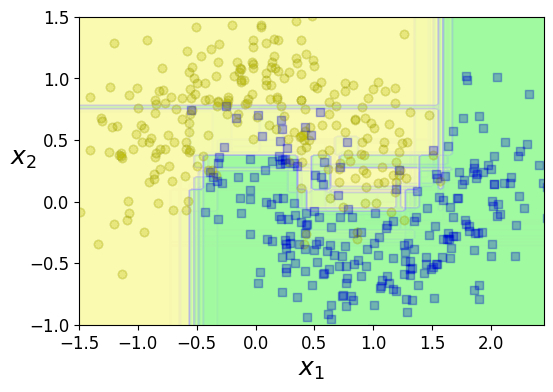

In [25]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X_train[indices_with_replacement], y_train[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

plt.show()


Code to generate Figure 7–6. MNIST pixel importance (according to a Random Forest classifier):

Warning: since Scikit-Learn 0.24, fetch_openml() returns a Pandas DataFrame by default. To avoid this and keep the same code as in the book, we use as_frame=False.

In [27]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [28]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [29]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

Saving figure mnist_feature_importance_plot


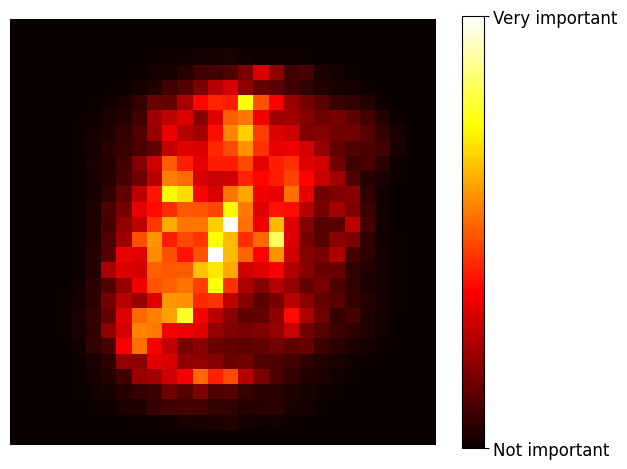

In [30]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()


# Boosting

Boosting (originally called hypothesis boosting) refers to any Ensemble method that
 can combine several weak learners into a strong learner. The general idea of most
 boosting methods is to train predictors sequentially, each trying to correct its prede
cessor. There are many boosting methods available, but by far the most popular are AdaBoost (short for Adaptive Boosting) and Gradient Boosting. Let’s start with Ada
Boost.
# AdaBoost

 One way for a new predictor to correct its predecessor is to pay a bit more attention
 to the training instances that the predecessor underfitted. This results in new predic
tors focusing more and more on the hard cases. This is the technique used by
 AdaBoost.

 For example, when training an AdaBoost classifier, the algorithm first trains a base
 classifier (such as a Decision Tree) and uses it to make predictions on the training set.
 The algorithm then increases the relative weight of misclassified training instances.
 Then it trains a second classifier, using the updated weights, and again makes predic
tions on the training set, updates the instance weights, and so on (see Figure 7-7)

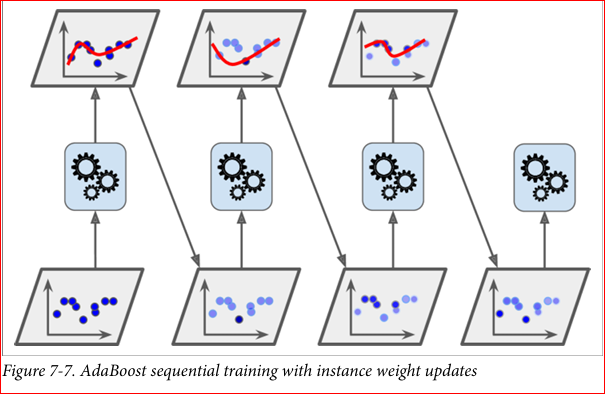

In [32]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

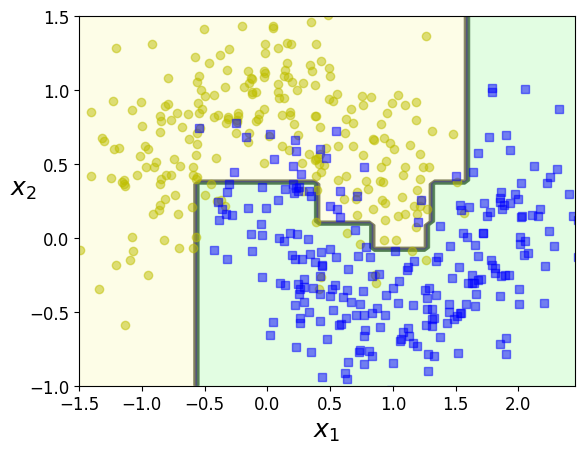

In [33]:
plot_decision_boundary(ada_clf, X, y)

**Code to generate Figure 7–8. Decision boundaries of consecutive predictors:**

Saving figure boosting_plot


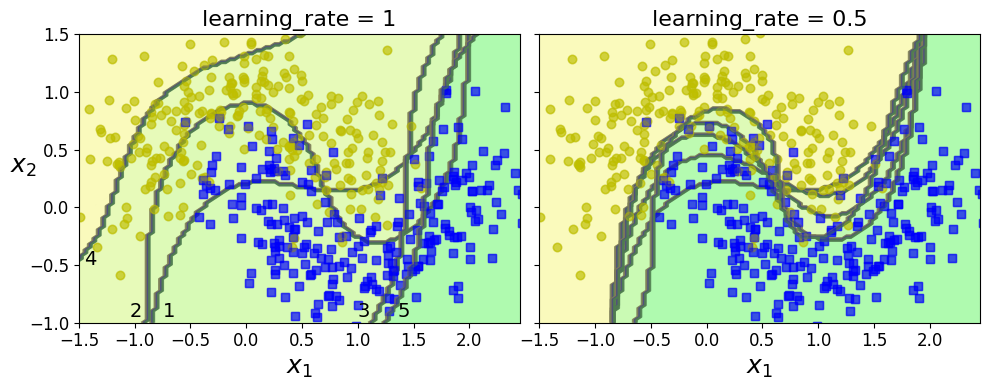

In [34]:
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step

        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=14)
        plt.text(-1.05, -0.95, "2", fontsize=14)
        plt.text(1.0, -0.95, "3", fontsize=14)
        plt.text(-1.45, -0.5, "4", fontsize=14)
        plt.text(1.36,  -0.95, "5", fontsize=14)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

 Figure 7-8 shows the decision boundaries of five consecutive predictors on the
 moons dataset (in this example, each predictor is a highly regularized SVM classifier
 with an RBF kernel14). The first classifier gets many instances wrong, so their weights
get boosted. The second classifier therefore does a better job on these instances, and
 so on. The plot on the right represents the same sequence of predictors, except that
 the learning rate is halved (i.e., the misclassified instance weights are boosted half as
 much at every iteration). As you can see, this sequential learning technique has some
 similarities with Gradient Descent, except that instead of tweaking a single predictor’s
 parameters to minimize a cost function, AdaBoost adds predictors to the ensemble,
 gradually making it better.

# Gradient Boosting

 Another very popular boosting algorithm is Gradient Boosting.17 Just like AdaBoost,
 Gradient Boosting works by sequentially adding predictors to an ensemble, each one
 correcting its predecessor. However, instead of tweaking the instance weights at every
 iteration like AdaBoost does, this method tries to fit the new predictor to the residual
 errors made by the previous predictor.
 Let’s go through a simple regression example, using Decision Trees as the base predic
tors (of course, Gradient Boosting also works great with regression tasks). This is
 called Gradient Tree Boosting, or Gradient Boosted Regression Trees (GBRT). First, let’s
 fit a DecisionTreeRegressor to the training set (for example, a noisy quadratic train
ing set)

**Let create a simple quadratic dataset:**

In [36]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

Now let's train a decision tree regressor on this dataset:

In [37]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Next, we’ll train a second DecisionTreeRegressor on the residual errors made by the
 first predictor:

In [38]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

 Then we train a third regressor on the residual errors made by the second predictor

In [39]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [40]:
X_new = np.array([[0.8]])

 Now we have an ensemble containing three trees. It can make predictions on a new
 instance simply by adding up the predictions of all the trees

In [41]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [42]:
y_pred

array([0.75026781])

 Figure 7-9 represents the predictions of these three trees in the left column, and the
 ensemble’s predictions in the right column. In the first row, the ensemble has just one
 tree, so its predictions are exactly the same as the first tree’s predictions. In the second
 row, a new tree is trained on the residual errors of the first tree. On the right you can
 see that the ensemble’s predictions are equal to the sum of the predictions of the first
 two trees. Similarly, in the third row another tree is trained on the residual errors of
 the second tree. You can see that the ensemble’s predictions gradually get better as
 trees are added to the ensemble.



 **Code to generate Figure 7–9. In this depiction of Gradient Boosting, the first predictor (top left) is trained normally, then each consecutive predictor (middle left and lower left) is trained on the previous predictor’s residuals; the right column shows the resulting ensemble’s predictions:**

In [43]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure gradient_boosting_plot


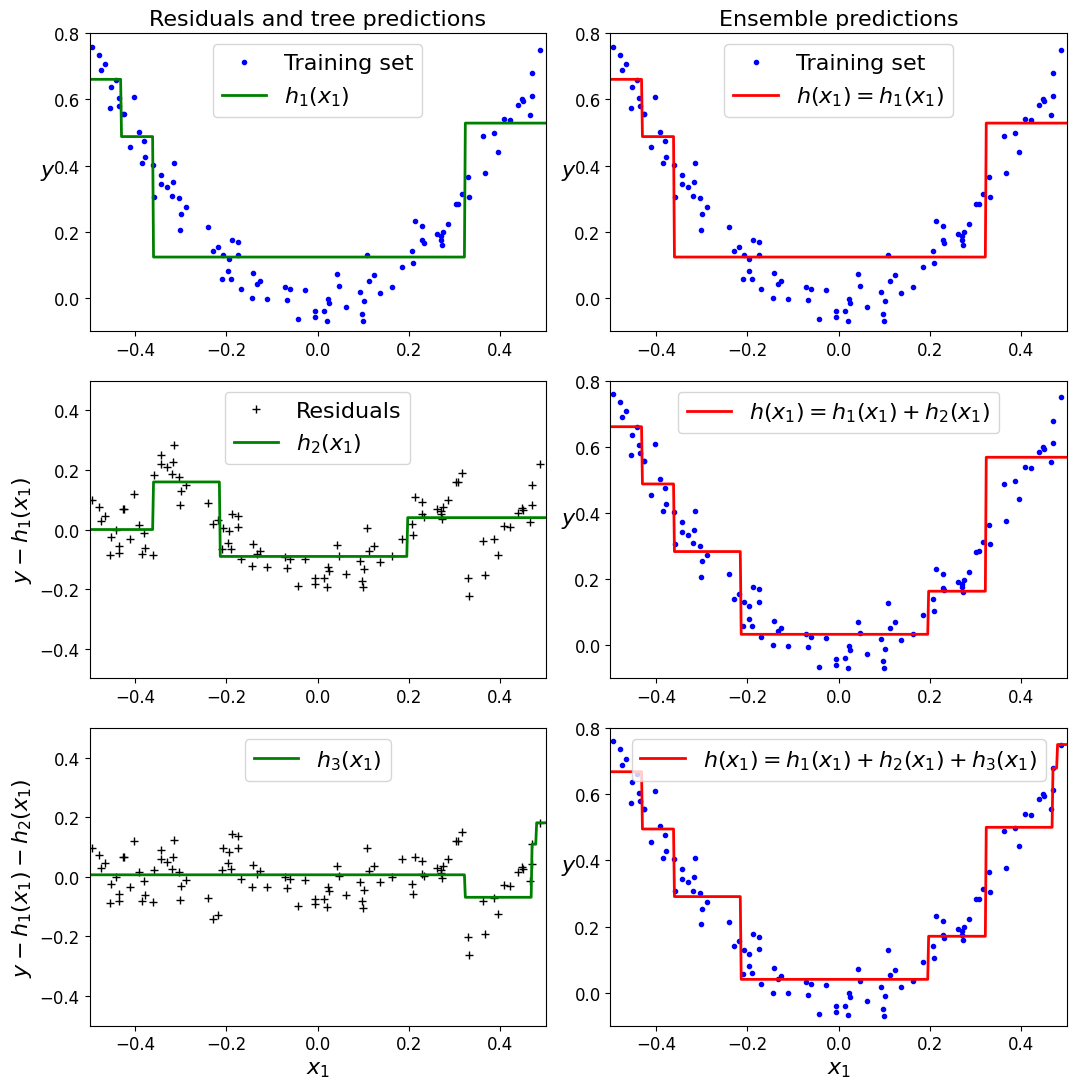

In [44]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

Now let's try a gradient boosting regressor:

from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

In [46]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

Saving figure gbrt_learning_rate_plot


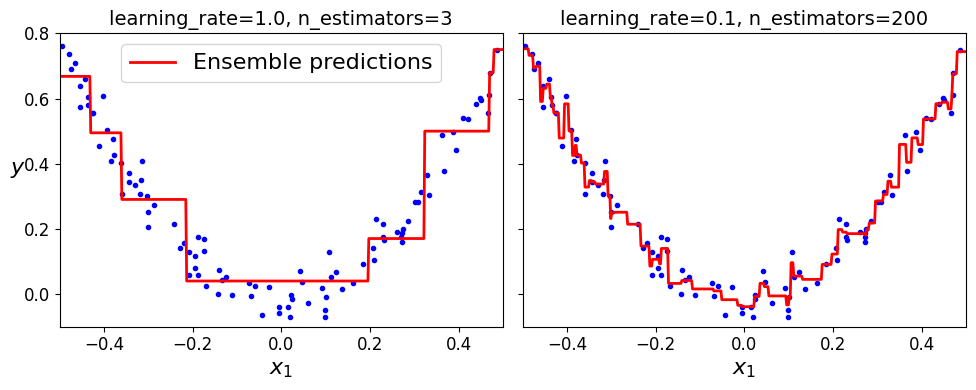

In [49]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

 The learning_rate hyperparameter scales the contribution of each tree. If you set it
 to a low value, such as 0.1, you will need more trees in the ensemble to fit the train
ing set, but the predictions will usually generalize better. This is a regularization tech
nique called shrinkage. Figure 7-10 shows two GBRT ensembles trained with a low
 learning rate: the one on the left does not have enough trees to fit the training set,
 while the one on the right has too many trees and overfits the training set.

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)


# Gradient Boosting with Early stopping:

 In order to find the optimal number of trees, you can use early stopping (see Chap
ter 4). A simple way to implement this is to use the staged_predict() method: it
 returns an iterator over the predictions made by the ensemble at each stage of train
ing (with one tree, two trees, etc.). The following code trains a GBRT ensemble with
 120 trees, then measures the validation error at each stage of training to find the opti
mal number of trees, and finally trains another GBRT ensemble using the optimal
 number of trees

In [50]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=np.int64(56),
                          random_state=42)


**Code to generate Figure 7–11. Tuning thenumber of trees using early stopping**

In [51]:
min_error = np.min(errors)

Saving figure early_stopping_gbrt_plot


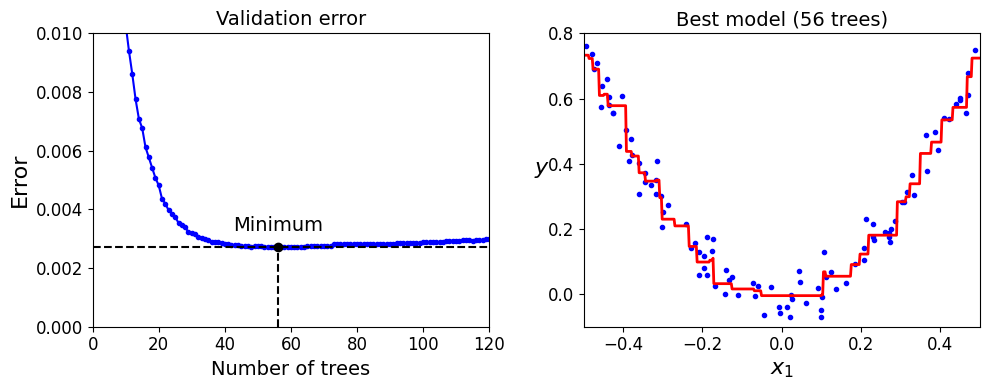

In [52]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

 It is also possible to implement early stopping by actually stopping training early
 (instead of training a large number of trees first and then looking back to find the
 optimal number). You can do so by setting warm_start=True, which makes Scikit
Learn keep existing trees when the fit() method is called, allowing incremental
 training. The following code stops training when the validation error does not
 improve for five iterations in a row


**Early stopping with some patience (interrupts training only after there's no improvement for 5 epochs):**

In [53]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [54]:
print(gbrt.n_estimators)

61


In [55]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463



# Using XGBoost:

 It is worth noting that an optimized implementation of Gradient Boosting is available
 in the popular Python library XGBoost, which stands for Extreme Gradient Boosting.
 This package was initially developed by Tianqi Chen as part of the Distributed (Deep)
 Machine Learning Community (DMLC), and it aims to be extremely fast, scalable,
 and portable. In fact, XGBoost is often an important component of the winning
 entries in ML competitions. XGBoost’s API is quite similar to Scikit-Learn’s

In [56]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

In [57]:
if xgboost is not None:  # not shown in the book
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) # Not shown
    print("Validation MSE:", val_error)           # Not shown

Validation MSE: 0.004644479346317078


In [77]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Convert data to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

evallist = [(dval, 'eval')]
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    evals=evallist,
    early_stopping_rounds=2,
    verbose_eval=False
)

# Predict and evaluate
y_pred = bst.predict(dval)
val_error = mean_squared_error(y_val, y_pred)
print("Validation MSE:", val_error)



Validation MSE: 0.0032285372184991546


 XGBoost also offers several nice features, such as automatically taking care of early
 stopping

In [78]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

The slowest run took 8.45 times longer than the fastest. This could mean that an intermediate result is being cached.
64.4 ms ± 58.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [79]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

95.5 ms ± 18.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Stacking

 The last Ensemble method we will discuss in this chapter is called stacking (short for
 stacked generalization).18 It is based on a simple idea: instead of using trivial functions
 (such as hard voting) to aggregate the predictions of all predictors in an ensemble,
 why don’t we train a model to perform this aggregation? Figure 7-12 shows such an
 ensemble performing a regression task on a new instance. Each of the bottom three
 predictors predicts a different value (3.1, 2.7, and 2.9), and then the final predictor
 (called a blender, or a meta learner) takes these predictions as inputs and makes the
 final prediction (3.0)

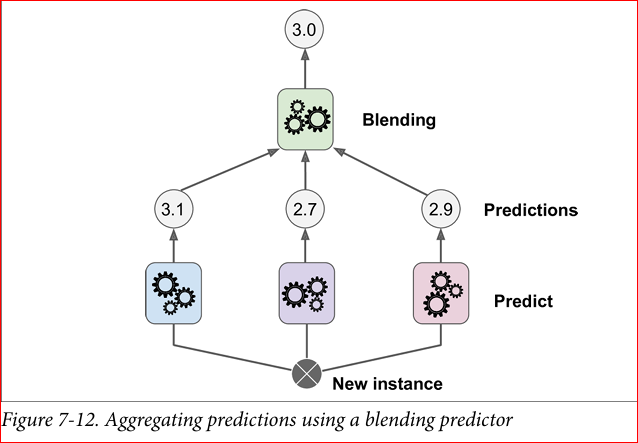

 To train the blender, a common approach is to use a hold-out set.19 Let’s see how it
 works. First, the training set is split into two subsets. The first subset is used to train
 the predictors in the first layer (see Figure 7-13)

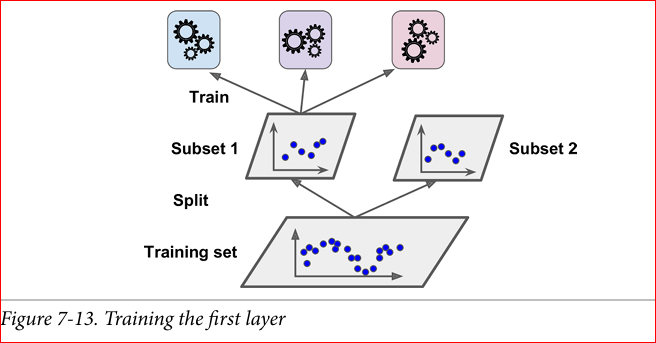

 Next, the first layer’s predictors are used to make predictions on the second (held
out) set (see Figure 7-14). This ensures that the predictions are “clean,” since the pre
dictors never saw these instances during training. For each instance in the hold-out
 19 Alternatively, it is possible to use out-of-fold predictions. In some contexts this is called stacking, while using a
 hold-out set is called blending. For many people these terms are synonymous.

set, there are three predicted values. We can create a new training set using these pre
dicted values as input features (which makes this new training set 3D), and keeping
 the target values. The blender is trained on this new training set, so it learns to pre
dict the target value, given the first layer’s predictions

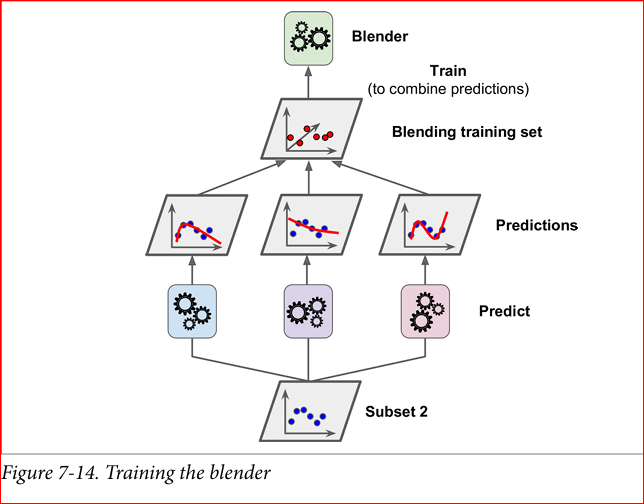

 It is actually possible to train several different blenders this way (e.g., one using Lin
ear Regression, another using Random Forest Regression), to get a whole layer of
 blenders. The trick is to split the training set into three subsets: the first one is used to
 train the first layer, the second one is used to create the training set used to train the
 second layer (using predictions made by the predictors of the first layer), and the
 third one is used to create the training set to train the third layer (using predictions
 made by the predictors of the second layer). Once this is done, we can make a predic
tion for a new instance by going through each layer sequentially, as shown in
 Figure 7-15

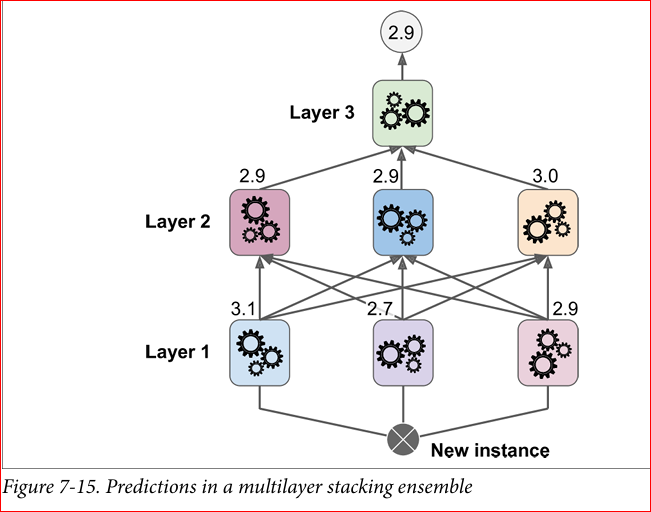

Unfortunately, Scikit-Learn does not support stacking directly, but it is not too hard
 to roll out your own implementation (see the following exercises). Alternatively, you
 can use an open source implementation such as DESlib